In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install openpyxl

In [3]:
import pandas as pd
from IPython.display import display



# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score,
                             roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
patients_file = "/content/drive/My Drive/patients.csv"
conditions_file = "/content/drive/My Drive/conditions.csv"
encounters_file = "/content/drive/My Drive/encounters.csv"
observations_file = "/content/drive/My Drive/observations.csv"

# Load patients
patients = pd.read_csv(patients_file)
print("Patients shape:", patients.shape)

# Load conditions
conditions = pd.read_csv(conditions_file)
print("Conditions shape:", conditions.shape)

# Load encounters
encounters = pd.read_csv(encounters_file)
print("Encounters shape:", encounters.shape)


Patients shape: (22818, 28)
Conditions shape: (872128, 7)
Encounters shape: (1497468, 15)


In [5]:
!unzip /content/drive/MyDrive/observations.zip

Archive:  /content/drive/MyDrive/observations.zip
  inflating: observations 1.csv      


In [9]:
# Load observations in chunks
chunksize = 100_000
obs_chunks = []
for chunk in pd.read_csv(observations_file, chunksize=chunksize):
    obs_chunks.append(chunk)
observations = pd.concat(obs_chunks, ignore_index=True)
print("Observations shape:", observations.shape)

Observations shape: (19161370, 9)


In [38]:
bmi_variants = observations[observations["DESCRIPTION"].str.contains("Body Mass Index|BMI", case=False, na=False)]
print("BMI-related DESCRIPTIONs:", bmi_variants["DESCRIPTION"].unique())
print("Number of BMI rows:", len(bmi_variants))
print(bmi_variants.head())

BMI-related DESCRIPTIONs: ['Body mass index (BMI) [Ratio]'
 'Body mass index (BMI) [Percentile] Per age and sex']
Number of BMI rows: 359190
                     DATE                               PATIENT  \
117  2022-06-08T07:00:09Z  3677432a-971b-7ef0-acbb-43ce84a150cc   
118  2022-06-08T07:00:09Z  3677432a-971b-7ef0-acbb-43ce84a150cc   
130  2022-12-07T07:00:09Z  3677432a-971b-7ef0-acbb-43ce84a150cc   
131  2022-12-07T07:00:09Z  3677432a-971b-7ef0-acbb-43ce84a150cc   
143  2023-06-07T07:00:09Z  3677432a-971b-7ef0-acbb-43ce84a150cc   

                                ENCOUNTER     CATEGORY     CODE  \
117  a5198709-992d-4324-8419-fe1d5b44b268  vital-signs  39156-5   
118  a5198709-992d-4324-8419-fe1d5b44b268  vital-signs  59576-9   
130  e6ee601f-5a97-d322-d026-f317113e9e0f  vital-signs  39156-5   
131  e6ee601f-5a97-d322-d026-f317113e9e0f  vital-signs  59576-9   
143  9391b283-6017-a74b-e356-dc26b166af19  vital-signs  39156-5   

                                           DESCRIPTIO

In [30]:
ckd_codes = [
    "709044004",  # Chronic kidney disease
    "127013003",  # Diabetic nephropathy
    "90708001",   # Kidney disease
    "236570004",  # CKD stage 3
    "236571000",  # CKD stage 4
]

In [31]:
ckd_rows = conditions[conditions["CODE"].astype(str).isin(ckd_codes)]
ckd_patient_ids = set(ckd_rows["PATIENT"])
print("Total CKD patients from conditions:", len(ckd_patient_ids))

Total CKD patients from conditions: 3162


In [32]:
#Label each patient
patients["ckd_label"] = patients["Id"].apply(lambda pid: 1 if pid in ckd_patient_ids else 0)

In [33]:
print("\n--- Basic EDA ---")
print("Label distribution:\n", patients["ckd_label"].value_counts())
print("\nPercentage of patients with CKD:",
      patients["ckd_label"].mean() * 100, "%")


--- Basic EDA ---
Label distribution:
 ckd_label
0    19656
1     3162
Name: count, dtype: int64

Percentage of patients with CKD: 13.857480936103075 %


In [39]:
# Step 5: Feature mapping
feature_map = {
    "Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum or Plasma by Creatinine-based formula (MDRD)": "egfr",
    "Microalbumin/Creatinine [Mass Ratio] in Urine": "albumin_creatinine",
    "Glucose [Mass/volume] in Blood": "glucose",
    "Hemoglobin A1c/Hemoglobin.total in Blood": "hba1c",
    "Body mass index (BMI) [Ratio]": "bmi",  # Ensure this is included
    "Systolic Blood Pressure": "systolic_bp",
    "Diastolic Blood Pressure": "diastolic_bp",
}

In [40]:
# Step 6: Filter and process observations
obs_filtered = observations[observations["DESCRIPTION"].isin(feature_map.keys())].copy()
print("Rows in obs_filtered:", len(obs_filtered))
print("Unique DESCRIPTIONs in obs_filtered:", obs_filtered["DESCRIPTION"].unique())

obs_filtered["feature"] = obs_filtered["DESCRIPTION"].map(feature_map)
print("Unique features in obs_filtered:", obs_filtered["feature"].unique())

obs_filtered["VALUE"] = pd.to_numeric(obs_filtered["VALUE"], errors="coerce")
obs_filtered["DATE"] = pd.to_datetime(obs_filtered["DATE"], errors="coerce")
obs_filtered.sort_values("DATE", inplace=True)
latest_obs = obs_filtered.groupby(["PATIENT", "feature"], as_index=False).last()
print("Latest observations shape:", latest_obs.shape)
print(latest_obs.head())

patient_features = latest_obs.pivot(index="PATIENT", columns="feature", values="VALUE").reset_index()
patient_features.rename(columns={"PATIENT": "Id"}, inplace=True)
print("Patient features shape:", patient_features.shape)
print("Columns in patient_features:", patient_features.columns.tolist())
print(patient_features.head())

Rows in obs_filtered: 1694217
Unique DESCRIPTIONs in obs_filtered: ['Diastolic Blood Pressure' 'Systolic Blood Pressure'
 'Body mass index (BMI) [Ratio]'
 'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum or Plasma by Creatinine-based formula (MDRD)'
 'Hemoglobin A1c/Hemoglobin.total in Blood'
 'Glucose [Mass/volume] in Blood'
 'Microalbumin/Creatinine [Mass Ratio] in Urine']
Unique features in obs_filtered: ['diastolic_bp' 'systolic_bp' 'bmi' 'egfr' 'hba1c' 'glucose'
 'albumin_creatinine']
Latest observations shape: (94422, 10)
                                PATIENT       feature  \
0  0000ce8b-d02f-56b8-92e7-e7a027f0b75c           bmi   
1  0000ce8b-d02f-56b8-92e7-e7a027f0b75c  diastolic_bp   
2  0000ce8b-d02f-56b8-92e7-e7a027f0b75c   systolic_bp   
3  0000f379-6d8a-044d-5922-a9635d745741           bmi   
4  0000f379-6d8a-044d-5922-a9635d745741  diastolic_bp   

                       DATE                             ENCOUNTER  \
0 1952-11-18 17:17:41+00:00

In [42]:
print("Unique features in obs_filtered:")
print(obs_filtered["feature"].unique())

Unique features in obs_filtered:
['diastolic_bp' 'systolic_bp' 'bmi' 'egfr' 'glucose' 'hba1c'
 'albumin_creatinine']


In [43]:
# Step 7: Merge with patients and encounters
final_df = pd.merge(patients, patient_features, on="Id", how="left")
encounter_counts = encounters.groupby("PATIENT").size().reset_index(name="encounter_count")
encounter_counts.rename(columns={"PATIENT": "Id"}, inplace=True)
final_df = pd.merge(final_df, encounter_counts, on="Id", how="left")
final_df["encounter_count"] = final_df["encounter_count"].fillna(0)
final_df.head(25)

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,MIDDLE,LAST,...,INCOME,ckd_label,albumin_creatinine,bmi,diastolic_bp,egfr,glucose,hba1c,systolic_bp,encounter_count
0,3677432a-971b-7ef0-acbb-43ce84a150cc,2020-01-01,NaN,999-60-9177,NaN,NaN,NaN,Carlos172,Gregorio366,Estévez304,...,134859,0,NaN,15.4,80.0,NaN,NaN,NaN,132.0,17
1,3e635a70-e4f8-0dab-0cea-e241e603d1c6,2008-10-13,NaN,999-76-7313,S99990286,NaN,NaN,Cathi439,Sana377,Fay398,...,44942,0,NaN,23.2,68.0,NaN,NaN,NaN,127.0,22
2,146b2833-24a9-8087-70b2-f73790020184,1981-08-08,2010-12-22,999-67-8888,S99969795,X68345241X,Mr.,Nickolas58,Jed345,Adams676,...,90252,0,NaN,29.2,57.0,105.4,89.5,5.4,101.0,23
3,7b00b9f8-8b8c-1338-4219-7c291cb09495,1996-04-24,NaN,999-64-6927,S99911456,X46352131X,Mr.,Felipe97,NaN,Muñoz828,...,135225,0,NaN,28.6,74.0,NaN,NaN,NaN,114.0,13
4,bbb163df-264a-71aa-e4d8-091553d95dd1,1982-05-04,NaN,999-79-2179,S99950614,X75923971X,Mrs.,Ping698,Natasha268,Jacobi462,...,45191,0,NaN,30.0,84.0,NaN,NaN,NaN,144.0,95
5,d94d4ff3-d283-14e9-30ac-85a84d88884e,1998-09-24,NaN,999-74-4454,S99917189,X9823555X,Mr.,Juan Carlos348,Jorge Luis88,Serrano248,...,146632,0,NaN,24.5,86.0,NaN,93.9,6.1,135.0,47
6,1682a33d-d7a4-b11b-a959-8dcd111e0b57,1989-07-12,NaN,999-85-2916,S99937664,X4862269X,Mrs.,Alesia841,Vickie113,Douglas31,...,129711,1,NaN,26.5,70.0,73.4,NaN,NaN,94.0,114
7,c526b174-e83d-192f-2cdf-ebf915d087e1,1989-07-12,NaN,999-74-5590,S99966863,X79992915X,Mr.,Elmer371,Kermit56,Graham902,...,11268,0,NaN,23.4,81.0,NaN,NaN,NaN,106.0,24
8,b2ccb1cc-c47d-e3cf-5ab0-6930b998359f,1988-04-07,NaN,999-95-6048,S99969967,X33956329X,Mrs.,Carmon128,Ardath226,Dibbert990,...,46803,0,NaN,27.8,93.0,NaN,NaN,NaN,117.0,45
9,047b372c-98ed-c57e-e55e-a74f11d8fdba,1991-09-17,NaN,999-77-3868,S99912287,X72195682X,Mr.,Deon400,Coleman27,Kuvalis369,...,827,0,NaN,27.9,66.0,NaN,72.9,6.0,120.0,89


In [44]:
# Step 8: Calculate age
final_df["AGE"] = pd.to_datetime(final_df["BIRTHDATE"], errors="coerce").apply(
    lambda dob: datetime.now().year - dob.year if pd.notnull(dob) else np.nan
)
final_df.head(5)

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,MIDDLE,LAST,...,ckd_label,albumin_creatinine,bmi,diastolic_bp,egfr,glucose,hba1c,systolic_bp,encounter_count,AGE
0,3677432a-971b-7ef0-acbb-43ce84a150cc,2020-01-01,NaN,999-60-9177,NaN,NaN,NaN,Carlos172,Gregorio366,Estévez304,...,0,NaN,15.4,80.0,NaN,NaN,NaN,132.0,17,5
1,3e635a70-e4f8-0dab-0cea-e241e603d1c6,2008-10-13,NaN,999-76-7313,S99990286,NaN,NaN,Cathi439,Sana377,Fay398,...,0,NaN,23.2,68.0,NaN,NaN,NaN,127.0,22,17
2,146b2833-24a9-8087-70b2-f73790020184,1981-08-08,2010-12-22,999-67-8888,S99969795,X68345241X,Mr.,Nickolas58,Jed345,Adams676,...,0,NaN,29.2,57.0,105.4,89.5,5.4,101.0,23,44
3,7b00b9f8-8b8c-1338-4219-7c291cb09495,1996-04-24,NaN,999-64-6927,S99911456,X46352131X,Mr.,Felipe97,NaN,Muñoz828,...,0,NaN,28.6,74.0,NaN,NaN,NaN,114.0,13,29
4,bbb163df-264a-71aa-e4d8-091553d95dd1,1982-05-04,NaN,999-79-2179,S99950614,X75923971X,Mrs.,Ping698,Natasha268,Jacobi462,...,0,NaN,30.0,84.0,NaN,NaN,NaN,144.0,95,43


In [45]:
print(final_df.columns)

Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'INCOME', 'ckd_label', 'albumin_creatinine',
       'bmi', 'diastolic_bp', 'egfr', 'glucose', 'hba1c', 'systolic_bp',
       'encounter_count', 'AGE'],
      dtype='object')


In [48]:
columns_to_keep = [
     "ckd_label", "AGE",
    "egfr", "albumin_creatinine", "glucose", "hba1c", "bmi",
    "systolic_bp", "diastolic_bp", "encounter_count"
]
final_df_cleaned = final_df[columns_to_keep]
print("Final columns:", final_df_cleaned.columns.tolist())

Final columns: ['ckd_label', 'AGE', 'egfr', 'albumin_creatinine', 'glucose', 'hba1c', 'bmi', 'systolic_bp', 'diastolic_bp', 'encounter_count']


In [49]:
final_df_cleaned.head(5)

,ckd_label,AGE,egfr,albumin_creatinine,glucose,hba1c,bmi,systolic_bp,diastolic_bp,encounter_count
0,0,5,NaN,NaN,NaN,NaN,15.4,132.0,80.0,17
1,0,17,NaN,NaN,NaN,NaN,23.2,127.0,68.0,22
2,0,44,105.4,NaN,89.5,5.4,29.2,101.0,57.0,23
3,0,29,NaN,NaN,NaN,NaN,28.6,114.0,74.0,13
4,0,43,NaN,NaN,NaN,NaN,30.0,144.0,84.0,95


In [50]:
# Step 10: EDA on features
print("\n--- Feature Summary ---")
print(final_df_cleaned.describe())
print("\nMissing values:\n", final_df_cleaned.isnull().sum())


--- Feature Summary ---
          ckd_label           AGE         egfr  albumin_creatinine  \
count  22818.000000  22818.000000  6350.000000         1434.000000   
mean       0.138575     42.871812    64.525291           31.609902   
std        0.345510     25.712398    41.824446           80.536449   
min        0.000000      0.000000     2.500000            0.000000   
25%        0.000000     22.000000    21.900000            4.900000   
50%        0.000000     41.000000    70.200000            9.900000   
75%        0.000000     61.000000    87.300000           15.275000   
max        1.000000    111.000000   160.900000          584.600000   

           glucose        hba1c           bmi   systolic_bp  diastolic_bp  \
count  9764.000000  9103.000000  22135.000000  22818.000000  22818.000000   
mean     85.109812     5.470394     26.337972    118.700259     79.803537   
std      15.271545     1.240545      4.824319     15.475279     11.061526   
min      64.000000     2.300000     

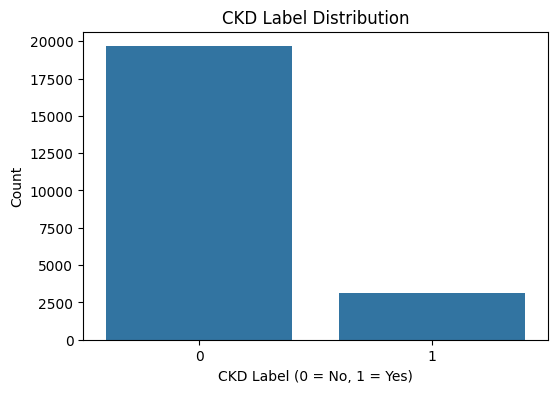

In [51]:
# Visualize label distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.countplot(x="ckd_label", data=final_df_cleaned)
plt.title("CKD Label Distribution")
plt.xlabel("CKD Label (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [52]:
# Step 11: Handle missing values (median imputation)
lab_cols = ["egfr", "albumin_creatinine", "glucose", "hba1c", "bmi", "systolic_bp", "diastolic_bp", "encounter_count"]
final_df_cleaned[lab_cols] = final_df_cleaned[lab_cols].fillna(final_df_cleaned[lab_cols].median())

<ipython-input-52-27ba8a8723c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_cleaned[lab_cols] = final_df_cleaned[lab_cols].fillna(final_df_cleaned[lab_cols].median())


In [53]:
# Step 12: Train model
X = final_df_cleaned[lab_cols + ["AGE"]]
y = final_df_cleaned["ckd_label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced_subsample",
    random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [54]:
# Step 13: Predict and evaluate with all metrics
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

In [55]:
# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3932
           1       0.98      0.93      0.95       632

    accuracy                           0.99      4564
   macro avg       0.98      0.96      0.97      4564
weighted avg       0.99      0.99      0.99      4564




--- Confusion Matrix ---
[[3917   15]
 [  43  589]]


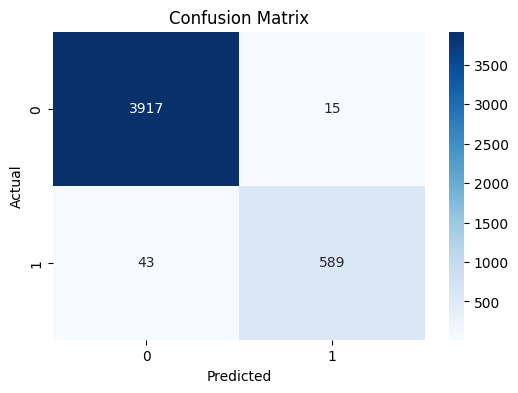

In [56]:
# Confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()